# Jugando contra Hikaru Nakamura

<p style="float: right; margin-left: 15px;">
  <img src="Nakamura_foto.jpg" width="230">
</p>

Hikaru Nakamura es un Gran Maestro Internacional de ajedrez nacido en Japón y nacionalizado estadounidense. Reconocido por su estilo de juego agresivo y su rapidez mental, ha sido cinco veces campeón de Estados Unidos y es uno de los mejores jugadores de ajedrez blitz del mundo. Además de su exitosa carrera competitiva, Nakamura es una figura influyente en el mundo digital, conocido por sus transmisiones en vivo y su presencia en plataformas como Twitch y YouTube, donde ha contribuido significativamente a la popularización del ajedrez en línea.

Además, como hemos visto en el *notebook 02_selección_jugador*, se ha mostrado muy activo en los dos últimos años siendo el jugador con más partidas de nuestra base de datos (2969 partidas -> 1492 partidas con blancas y 1477 con negras). 

A través de un modelo (red neuronal convolucional) entrenado con las partidas de este jugador generaremos un `jugador artificial` (bot) que responderá a nuestras jugadas al estilo Nakamura. Para ello, usando el motor Stockfish se generarán n=5 posibles movimientos que serán evaluados por nuestro modelo para tomar aquel que más se aproxime a la forma de jugar de este Gran Maestro. Todo ello siempre y cuando estos posibles valores superen un umbral preestrablecido. Si las jugadas en cuestión no se parecen en nada con las que ha entrenado nuestro modelo este devolverá muy probablemente un valor inferior al umbral y en este caso se elegirá la jugada que decida Stockfish (restringida al ELO del jugador).

In [ ]:
!pip install pygame
!pip install tensorflow

In [2]:
!pip install stockfish

In [ ]:
!pip install scikit-learn

In [4]:
# Paquetes necesarios
import pygame
import chess
import numpy as np
import os
import chess
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from stockfish import Stockfish
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

pygame 2.6.1 (SDL 2.28.4, Python 3.9.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-05-09 07:20:28.404987: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 07:20:28.408557: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 07:20:28.422229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746775228.454914      37 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746775228.460769      37 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746775228.475338      37 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1.  Selección de partidas
Se generará un **único** archivo .pgn con las partidas del jugador objetivo = "Nakamura, Hi" (FideID = 2016192).

In [5]:
from pyspark.sql import SparkSession
from io import StringIO
import os
import chess.pgn
import subprocess

# Crear sesión Spark
spark = SparkSession.builder \
    .appName("FiltrarPorFideID") \
    .getOrCreate()
sc = spark.sparkContext

# 📁 Ruta en HDFS con los archivos PGN limpios
ruta_entrada = "/user/ajedrez/limpios"
fide_id_objetivo = "2016192"  # Por ejemplo: Nakamura
nombre = "Nakamura,Hi"

# 📂 Ruta de salida en HDFS
ruta_salida_hdfs = f"/user/ajedrez/partidas_individuales/"
archivo_salida_local = f"/tmp/partidas_jugador_{fide_id_objetivo}.pgn"

# Crear directorio de salida si no existe
subprocess.run(["hdfs", "dfs", "-mkdir", "-p", ruta_salida_hdfs])

# Leer archivos desde HDFS como texto
archivos_pgn = sc.wholeTextFiles(ruta_entrada + "/*.pgn")  # (ruta, contenido)

def filtrar_por_fide_id(ruta_y_contenido):
    _, contenido = ruta_y_contenido
    pgn_stream = StringIO(contenido)
    partidas = []

    while True:
        try:
            game = chess.pgn.read_game(pgn_stream)
            if game is None:
                break

            white_id = game.headers.get("WhiteFideId", "")
            black_id = game.headers.get("BlackFideId", "")

            if fide_id_objetivo in [white_id, black_id]:
                exporter = chess.pgn.StringExporter(headers=True, variations=True, comments=True)
                partidas.append(game.accept(exporter) + "\n\n")

        except Exception:
            continue

    return partidas

# 🔍 Aplicar el filtrado
partidas_filtradas = archivos_pgn.flatMap(filtrar_por_fide_id)
cantidad = partidas_filtradas.count()

print(f"🔎 Partidas encontradas para FIDE ID {fide_id_objetivo}: {cantidad}")

if cantidad > 0:
    # Guardar archivo temporal local
    with open(archivo_salida_local, "w", encoding="utf-8") as f:
        for partida in partidas_filtradas.collect():
            f.write(partida)

    # Subir a HDFS
    ruta_archivo_hdfs = ruta_salida_hdfs + f"partidas_jugador_{fide_id_objetivo}.pgn"
    subprocess.run(["hdfs", "dfs", "-rm", ruta_archivo_hdfs], stderr=subprocess.DEVNULL)
    subprocess.run(["hdfs", "dfs", "-put", archivo_salida_local, ruta_archivo_hdfs])
    print(f"✅ Se guardaron {cantidad} partidas de {nombre} en: {ruta_archivo_hdfs}")
else:
    print("⚠️ No se encontraron partidas para ese FIDE ID.")

spark.stop()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 07:23:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

🔎 Partidas encontradas para FIDE ID 2016192: 262


Deleted /user/ajedrez/partidas_individuales/partidas_jugador_2016192.pgn
✅ Se guardaron 262 partidas de Nakamura,Hi en: /user/ajedrez/partidas_individuales/partidas_jugador_2016192.pgn


## 2. Código para leer y procesar partidas PGN

Desarrollaremos un modelo de `aprendizaje supervisado`. Cada partida de ajedrez consiste en una secuencia de posiciones (tableros) 
y jugadas de respuesta a esa posición por parte de nuestro jugador. Esto es, tendremos pares (input, label):
- **Input:**  El tablero antes de que Nakamura mueva (notación FEN) en la columna "FEN". 
- **Label:** La jugada que hizo Nakamura en esa posición (por ejemplo, en formato UCI como 'e2e4' en la columna "Move".
Adicionalmente, tendremos en cuenta desde que color jugaba Nakamura en la columna "Color"


La **notación FEN** (por sus siglas en inglés: *Forsyth-Edwards Notation*) describe una posición específica del tablero utilizando una sola línea de texto. Es muy utilizada para guardar posiciones de forma compacta y precisa. Una cadena FEN contiene 6 campos, separados por espacios. Por ejemplo: `rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1`

Esto representa la posición inicial de una partida de ajedrez. Explicamos cada parte:

1. **Posición de las piezas:**  
   `rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR`  
   Describe el tablero fila por fila, de arriba (8ª fila) hacia abajo (1ª fila). Las letras representan las piezas:
   - Minúsculas = negras: `r`=torre, `n`=caballo, `b`=alfil, `q`=dama, `k`=rey, `p`=peón  
   - Mayúsculas = blancas: `R`=torre, `N`=caballo, etc.  
   Los números indican casillas vacías.

2. **Turno:**  
   `w` significa que le toca a las blancas jugar (`b` sería negras).

3. **Derechos de enroque:**  
   `KQkq` indica que ambos bandos pueden enrocarse en ambos flancos (K=blancas corto, Q=blancas largo, k=negras corto, q=negras largo). Si ningún jugador se puede enrocar, se usa `-`.

4. **Captura al paso:**  
   `-` indica que no hay captura al paso disponible. Si sí la hay, aparece la casilla objetivo (ej. `e3`).

5. **Regla de los 50 movimientos:**  
   `0` es el número de movimientos sin mover un peón ni capturar (para aplicar la regla de los 50 movimientos).

6. **Número de jugada:**  
   `1` es el número de jugada completa. Una jugada lo componen un movimiento de cada jugador, por tanto, aumenta en 1 después de cada jugada de las negras.

In [6]:
## Funciona pero es en LOCAL
import subprocess
import chess.pgn
import pandas as pd
from io import StringIO

# Parámetros
nombre_objetivo = "Nakamura,Hi".lower()
fide_id = "2016192"
archivo_hdfs = f"/user/ajedrez/partidas_individuales/partidas_jugador_{fide_id}.pgn"
archivo_local = f"partidas_nakamura_{fide_id}.pgn"
archivo_csv = f"movimientos_nakamura.csv"

# 1. Descargar desde HDFS a local
print("Descargando desde HDFS...")
subprocess.run(["hdfs", "dfs", "-get", "-f", archivo_hdfs, archivo_local], check=True)
print(f"Archivo descargado como: {archivo_local}")

# 2. Procesar el archivo PGN
datos = []

with open(archivo_local, encoding="utf-8", errors="ignore") as f:
    while True:
        try:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            white = game.headers.get("White", "").lower()
            black = game.headers.get("Black", "").lower()

            if nombre_objetivo in white:
                player_color = chess.WHITE
                color_label = "white"
            elif nombre_objetivo in black:
                player_color = chess.BLACK
                color_label = "black"
            else:
                continue

            board = game.board()

            for move in game.mainline_moves():
                if board.turn == player_color:
                    fen = board.fen()
                    datos.append((fen, move.uci(), color_label))
                board.push(move)

        except Exception:
            continue

# 3. Crear y guardar el DataFrame
df = pd.DataFrame(datos, columns=["FEN", "Move", "Color"])
#df.to_csv(archivo_csv, index=False, encoding="utf-8")
#print(f" Jugadas guardadas en CSV: {archivo_csv}")
print(df.head())


Descargando desde HDFS...
Archivo descargado como: partidas_nakamura_2016192.pgn
Empty DataFrame
Columns: [FEN, Move, Color]
Index: []


Ventajas de este enfoque:
No partes el PGN por trozos.

Usas Spark solo para cargar, procesar y guardar.

Solo usas un .coalesce(1) para evitar fragmentación, lo cual es seguro si tienes una única fuente.

In [1]:
from pyspark.sql import SparkSession
from io import StringIO
import chess.pgn

# Parámetros
nombre_objetivo = "Nakamura,Hi".lower()
ruta_archivo_hdfs = "/user/ajedrez/partidas_individuales/partidas_jugador_2016192.pgn"

# 1. Crear sesión Spark
spark = SparkSession.builder \
    .appName("ExtraerJugadasJugador") \
    .getOrCreate()
sc = spark.sparkContext

# 2. Leer el archivo como un solo bloque de texto (sin repartir)
contenido = sc.wholeTextFiles(ruta_archivo_hdfs).coalesce(1).map(lambda x: x[1])

# 3. Extraer jugadas directamente desde el contenido completo
def extraer_jugadas(texto):
    resultados = []
    pgn_stream = StringIO(texto)

    while True:
        try:
            game = chess.pgn.read_game(pgn_stream)
            if game is None:
                break

            white = game.headers.get("White", "").lower()
            black = game.headers.get("Black", "").lower()

            if nombre_objetivo in white:
                color = "white"
                jugador = chess.WHITE
            elif nombre_objetivo in black:
                color = "black"
                jugador = chess.BLACK
            else:
                continue

            board = game.board()
            for move in game.mainline_moves():
                if board.turn == jugador:
                    resultados.append((board.fen(), move.uci(), color))
                board.push(move)

        except Exception:
            continue

    return resultados

# 4. Ejecutar la extracción
jugadas_rdd = contenido.flatMap(extraer_jugadas)

# 5. Crear DataFrame
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([
    StructField("FEN", StringType(), False),
    StructField("Move", StringType(), False),
    StructField("Color", StringType(), False)
])

df = spark.createDataFrame(jugadas_rdd, schema=schema)
df.show(10, truncate=False)

# 6. Guardar en Parquet
ruta_salida = "/user/ajedrez/nakamura_movimientos/"
df.write.mode("overwrite").parquet(ruta_salida)
print(f"✅ Dataset guardado en HDFS: {ruta_salida}")

spark.stop()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 22:43:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

+---+----+-----+
|FEN|Move|Color|
+---+----+-----+
+---+----+-----+



✅ Dataset guardado en HDFS: /user/ajedrez/nakamura_movimientos/


In [4]:
df.shape
print(df.head())

(144521, 3)

r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


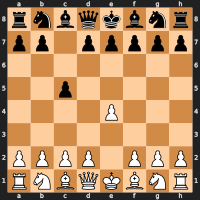

In [6]:
# FEN de ejemplo. Los dos primeros anteriores

#fen = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1"
fen = "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq"

# El tablero en la posición FEN descrita y el movimiento de Nakamura fue mover el caballo "g1f3" y 
# Nakamura jugaba con blancas

board = chess.Board(fen)

# Muestra el tablero con letras
print(board)

# Muestra el tablero como SVG
display(SVG(chess.svg.board(board=board,size=200)))

## 3. Convertir el estado FEN en una representación numérica

Lo que hace la función `fen_to_tensor(fen)` que aparece en la siguiente celda  es **convertir una posición de ajedrez en notación FEN a un tensor NumPy tridimensional**, que es una forma de representar la información que puede ser usada por modelos de inteligencia artificial o redes neuronales para procesar partidas de ajedrez.

#### ¿Cómo es el tensor? 
El tensor que devuelve tiene forma `(8, 8, 12)`:
- **8x8** = las casillas del tablero (filas y columnas).
- **12** = otra dimesión que indicará la pieza que está en esa casilla (6 tipos de pieza para cada color).


#### ¿Qué hace exactamente?

1. **Define un diccionario `piece_to_plane`:**  
   Asocia cada pieza (mayúscula = blanca, minúscula = negra) con un número del 0 al 11.  
   Ejemplo: `'P' → 0`, `'k' → 11`

2. **Crea un tensor lleno de ceros:**  
   Un array `8x8x12` donde todos los valores son inicialmente 0.

3. **Lee el tablero desde el FEN:**  
   Toma solo la parte del FEN que representa la posición de las piezas (la primera parte).

4. **Recorre cada fila del tablero:**  
   Va leyendo carácter por carácter:
   - Si el carácter es un número, significa "tantas casillas vacías".
   - Si es una letra (pieza), la coloca en la posición `(fila, columna, pieza)` del tensor, y marca ese punto como `1`.

5. **Devuelve el tensor final:**  
   Una representación del tablero que indica, para cada casilla, qué pieza está ahí (si hay alguna).

#### Ejemplo visual:

Supongamos que hay un peón blanco en e2.  
El tensor tendrá un `1` en la posición `[6][4][0]`, es decir:
- Fila 6 (que es la séptima pues comienza en 0). Las filas se cuentan de arriba hacia abajo.
- Columna 4 (que es la quinta, es decir, la columna "e") 
- Dimensión correspondiente a las piezas: pieza 0 (porque `'P'` es peón blanco)

In [5]:
# Vamos a codificar cada posición FEN en un elemento 8x8x12 
def fen_to_tensor(fen):  
    #Definición de la tercera dimensión, la correspondiente a la pieza.
    piece_to_plane = {   
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,  # Blancas
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11  # Negras
    }
    
    tensor = np.zeros((8, 8, 12), dtype=np.float32)
    fen_board = fen.split(' ')[0]
    rows = fen_board.split('/')
    
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            elif char in piece_to_plane:
                plane = piece_to_plane[char]
                tensor[i, col, plane] = 1
                col += 1
    return tensor

# Tensorización de tableros
df_white['Board_Tensor'] = df_white['FEN'].apply(fen_to_tensor)
df_black['Board_Tensor'] = df_black['FEN'].apply(fen_to_tensor)

# Codificar los movimientos del Dataframe (columna "Move") como etiquetas numéricas en una nueva
# columna del dataframe 

le_white = LabelEncoder()
df_white['Move_Label'] = le_white.fit_transform(df_white['Move'])

le_black = LabelEncoder()
df_black['Move_Label'] = le_black.fit_transform(df_black['Move'])

In [6]:
print(df_white.columns)
print(df_black.columns)

Index(['FEN', 'Move', 'Color', 'Board_Tensor', 'Move_Label'], dtype='object')
Index(['FEN', 'Move', 'Color', 'Board_Tensor', 'Move_Label'], dtype='object')


De este modo, desarrollaremos un modelo de `aprendizaje supervisado`. De este modo, cada partida consiste en una secuencia de posiciones (tableros) 
y jugadas de respuesta a esa posición por parte de nuestro jugador. Esto es, tendremos pares (input, label):
- **Input:**  El tablero antes de que Nakamura mueva FEN (codificado como una matriz 3-dimensional de tamaño 8x8x12 con ceros y unos). Está en la columna "Board_Tensor"
- **Label:** La jugada que hizo Nakamura en esa posición (por ejemplo, en formato UCI como 'e2e4'). Está en la columna "Move" y codificada en la columna Move_Label

## 4. Definición de la red neuronal convolucional


### 4.1 Modelo para BLANCAS

In [7]:
X_white = np.stack(df_white['Board_Tensor'].values)
y_white = np.array(df_white['Move_Label'])

# División de datos
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_white, y_white, test_size=0.1, random_state=42)

# Ajuste de forma
Xw_train = Xw_train.reshape(-1, 8, 8, 12)
Xw_test = Xw_test.reshape(-1, 8, 8, 12)

# Definir el modelo CNN para blancas
model_white = Sequential([
    Input(shape=(8, 8, 12)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(le_white.classes_), activation='softmax')
])

# Compilar
model_white.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar
history_white = model_white.fit(Xw_train, yw_train, epochs=10, validation_data=(Xw_test, yw_test), batch_size=32)

# Guardar modelo y encoder
model_white.save("modelo_blancas.keras")
np.save("encoder_blancas.npy", le_white.classes_)

Epoch 1/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.0326 - loss: 6.2073 - val_accuracy: 0.0732 - val_loss: 5.6488
Epoch 2/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.0787 - loss: 5.5224 - val_accuracy: 0.0962 - val_loss: 5.2775
Epoch 3/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.0996 - loss: 5.0944 - val_accuracy: 0.1111 - val_loss: 5.0282
Epoch 4/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.1202 - loss: 4.7166 - val_accuracy: 0.1308 - val_loss: 4.8611
Epoch 5/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.1384 - loss: 4.4038 - val_accuracy: 0.1384 - val_loss: 4.7893
Epoch 6/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1589 - loss: 4.1245 - val_accuracy: 0.1448 - val_loss: 4.6940
Epoch 7/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.1819 - loss: 3.8703 - val_accuracy: 0.1524 - val_loss: 4.7131
Epoch 8/10
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.2041 - loss: 3

### 4.2 Modelo para NEGRAS

In [11]:
X_black = np.stack(df_black['Board_Tensor'].values)
y_black = np.array(df_black['Move_Label'])

# División de datos
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_black, y_black, test_size=0.1, random_state=42)

# Ajuste de forma
Xb_train = Xb_train.reshape(-1, 8, 8, 12)
Xb_test = Xb_test.reshape(-1, 8, 8, 12)

# Definir el modelo CNN para negras
model_black = Sequential([
    Input(shape=(8, 8, 12)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(le_black.classes_), activation='softmax')
])

model_black.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_black = model_black.fit(Xb_train, yb_train, epochs=10, validation_data=(Xb_test, yb_test), batch_size=32)

model_black.save("modelo_negras.keras")
np.save("encoder_negras.npy", le_black.classes_)

Epoch 1/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.0239 - loss: 6.2968 - val_accuracy: 0.0659 - val_loss: 5.7140
Epoch 2/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.0655 - loss: 5.5990 - val_accuracy: 0.0972 - val_loss: 5.2879
Epoch 3/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.0947 - loss: 5.1291 - val_accuracy: 0.1113 - val_loss: 5.0069
Epoch 4/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1175 - loss: 4.7530 - val_accuracy: 0.1321 - val_loss: 4.8188
Epoch 5/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.1387 - loss: 4.4476 - val_accuracy: 0.1447 - val_loss: 4.7163
Epoch 6/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1536 - loss: 4.1880 - val_accuracy: 0.1508 - val_loss: 4.6501
Epoch 7/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1745 - loss: 3.9627 - val_accuracy: 0.1578 - val_loss: 4.6341
Epoch 8/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1929 - loss: 3

### Comentario: **"Asegurar que tiene canal final"**

Por defecto, **Keras usa el formato "canal al final"**, es decir: (batch_size, alto, ancho, canales).

En este caso:
- **8x8** es el tamaño del tablero (como una imagen de 8x8 píxeles)
- **12** representa los canales (las 12 piezas diferentes en ajedrez: 6 blancas y 6 negras)
- Entonces, cada "imagen" tiene forma **(8, 8, 12)**

La línea: X_train = X_train.reshape(-1, 8, 8, 12) significa: "reestructura `X_train` para que cada muestra tenga esa forma" (8x8x12), y `-1` le dice a NumPy que calcule automáticamente cuántas muestras hay. Luego la forma es (n_samples, height, width, channels).

**Nota**: Si ponemos más de 10 épocas se observa que comienza a haber overfitting. 
- La precisión de validación se mantiene muy por debajo de la de entrenamiento.
- La pérdida de validación comienza a aumentar mientras la de entrenamiento sigue bajando.

## 5. Evaluación entrenamiento

### 5.1 Evaluación entrenamiento con blancas

In [ ]:
# Precisión
plt.figure(figsize=(5, 3))
plt.plot(history_white.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history_white.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Pérdida
plt.figure(figsize=(5, 3))
plt.plot(history_white.history['loss'], label='Pérdida entrenamiento')
plt.plot(history_white.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()



### 5.2 Evaluación entrenamiento con blancas

## 6. Juego contra el Bot estilo Nakamura

### 6.1 Nakamura juega con blancas

In [13]:
import pygame
import chess
import numpy as np
from tensorflow.keras.models import load_model
from stockfish import Stockfish

# Configuración Pygame
pygame.init()
WIDTH, HEIGHT = 512, 512
SQ_SIZE = WIDTH // 8
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Juega contra Nakamura")

# Cargar imágenes de piezas
PIECE_IMAGES = {}
PIECE_MAPPING = {
    "r": "R1", "n": "N1", "b": "B1", "q": "Q1", "k": "K1", "p": "P1",
    "R": "R", "N": "N", "B": "B", "Q": "Q", "K": "K", "P": "P"
}
for symbol, name in PIECE_MAPPING.items():
    PIECE_IMAGES[symbol] = pygame.transform.scale(
        pygame.image.load(f"pieces/{name}.png"), (SQ_SIZE, SQ_SIZE))

# Cargar modelo y encoder
model = load_model("modelo_blancas.keras", compile=False)
encoder_classes = np.load("encoder_blancas.npy", allow_pickle=True)

# Iniciar Stockfish
stockfish = Stockfish(path="stockfish.exe", parameters={
    "Threads": 2,
    "Minimum Thinking Time": 100
})
stockfish.set_elo_rating(2800)
stockfish.set_skill_level(20)

# FEN a tensor
def fen_to_tensor(fen):
    piece_to_plane = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    tensor = np.zeros((8, 8, 12), dtype=np.float32)
    fen_board = fen.split(' ')[0]
    rows = fen_board.split('/')
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            elif char in piece_to_plane:
                tensor[i, col, piece_to_plane[char]] = 1
                col += 1
    return tensor

# Función para invertir la notación desde el punto de vista del jugador negro
def flip_square_name(uci_move):
    col_map = {'a': 'h', 'b': 'g', 'c': 'f', 'd': 'e', 'e': 'd', 'f': 'c', 'g': 'b', 'h': 'a'}
    def flip(sq):
        col, row = sq[0], sq[1]
        return col_map[col] + str(9 - int(row))
    return flip(uci_move[:2]) + flip(uci_move[2:4])

# Elegir jugada estilo Nakamura
def predict_move(fen, board, top_n=10, umbral_cp=20):
    stockfish.set_fen_position(fen)
    eval_info = stockfish.get_evaluation()

    if eval_info["type"] == "mate" and eval_info["value"] is not None and eval_info["value"] <= 3:
        best_uci = stockfish.get_best_move()
        print("¡Mate detectado! Stockfish lo ejecuta:", best_uci)
        return chess.Move.from_uci(best_uci)

    top_moves_info = stockfish.get_top_moves(top_n)
    if not top_moves_info:
        print("No hay jugadas válidas.")
        return np.random.choice(list(board.legal_moves))

    best_eval = top_moves_info[0].get("Centipawn")
    if best_eval is None:
        print("Evaluación no disponible. Stockfish mueve.")
        return chess.Move.from_uci(top_moves_info[0]["Move"])

    candidatas = []
    for move_info in top_moves_info:
        cp = move_info.get("Centipawn")
        if cp is not None and abs(best_eval - cp) <= umbral_cp:
            candidatas.append(move_info)

    if len(candidatas) == 1:
        best_move = chess.Move.from_uci(candidatas[0]["Move"])
        print("Jugada clara. Stockfish la ejecuta:", best_move.uci())
        return best_move

    tensor = fen_to_tensor(fen).reshape(1, 8, 8, 12)
    prediction = model.predict(tensor, verbose=0)[0]

    scored = []
    for move_info in candidatas:
        move_uci = move_info["Move"]
        try:
            idx = np.where(encoder_classes == move_uci)[0][0]
            ia_score = prediction[idx]
        except IndexError:
            ia_score = 0.0
        scored.append((move_uci, ia_score))

    best_uci, best_score = max(scored, key=lambda x: x[1])
    print(f"\n Jugada estilo Nakamura: {flip_square_name(best_uci)} (IA score: {best_score:.4f})")
    return chess.Move.from_uci(best_uci)

# Dibujar el tablero con negras abajo
def draw_board(board):
    colors = [pygame.Color("white"), pygame.Color("gray")]
    for row in range(8):
        for col in range(8):
            color = colors[(row + col) % 2]
            pygame.draw.rect(screen, color, pygame.Rect(col * SQ_SIZE, row * SQ_SIZE, SQ_SIZE, SQ_SIZE))

    for row in range(8):
        for col in range(8):
            visual_row = row
            visual_col = col
            square = chess.square(7 - visual_col, visual_row)
            piece = board.piece_at(square)
            if piece:
                img = PIECE_IMAGES.get(piece.symbol())
                if img:
                    screen.blit(img, (col * SQ_SIZE, row * SQ_SIZE))

# Bucle principal
board = chess.Board()
running = True
selected_square = None
game_over = False

draw_board(board)
pygame.display.flip()

# Primer movimiento IA (blancas)
ai_move = predict_move(board.fen(), board)
board.push(ai_move)

while running:
    draw_board(board)
    pygame.display.flip()

    if not game_over and board.is_game_over():
        game_over = True
        result = board.result()
        if board.is_checkmate():
            winner = "Blancas" if board.turn == chess.BLACK else "Negras"
            print(f"Jaque mate. Ganan {winner}")
        else:
            print("Tablas")

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.MOUSEBUTTONDOWN and not game_over:
            x, y = pygame.mouse.get_pos()
            col = 7 - (x // SQ_SIZE)
            row = y // SQ_SIZE
            square = chess.square(col, row)

            if selected_square is None:
                piece = board.piece_at(square)
                if piece and piece.color == chess.BLACK:
                    selected_square = square
            else:
                move = chess.Move(selected_square, square)
                if move in board.legal_moves:
                    board.push(move)
                    if not board.is_game_over():
                        ai_move = predict_move(board.fen(), board)
                        board.push(ai_move)
                selected_square = None

pygame.quit()



 Jugada estilo Nakamura: d7d5 (IA score: 0.2790)


### 6.2 Nakamura juega con negras

In [15]:
import pygame
import chess
import numpy as np
from tensorflow.keras.models import load_model
from stockfish import Stockfish

# Configuración Pygame
pygame.init()
WIDTH, HEIGHT = 512, 512
SQ_SIZE = WIDTH // 8
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Juega contra Nakamura (negras)")

# Cargar imágenes de piezas
PIECE_IMAGES = {}
PIECE_MAPPING = {
    "r": "R1", "n": "N1", "b": "B1", "q": "Q1", "k": "K1", "p": "P1",
    "R": "R", "N": "N", "B": "B", "Q": "Q", "K": "K", "P": "P"
}
for symbol, name in PIECE_MAPPING.items():
    PIECE_IMAGES[symbol] = pygame.transform.scale(
        pygame.image.load(f"pieces/{name}.png"), (SQ_SIZE, SQ_SIZE))

# Cargar modelo y encoder entrenado con negras
model = load_model("modelo_negras.keras", compile=False)
encoder_classes = np.load("encoder_negras.npy", allow_pickle=True)

# Iniciar Stockfish
stockfish = Stockfish(path="stockfish.exe", parameters={
    "Threads": 2,
    "Minimum Thinking Time": 100
})
stockfish.set_elo_rating(2800)
stockfish.set_skill_level(20)

# Convertir FEN a tensor
def fen_to_tensor(fen):
    piece_to_plane = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    tensor = np.zeros((8, 8, 12), dtype=np.float32)
    fen_board = fen.split(' ')[0]
    rows = fen_board.split('/')
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            elif char in piece_to_plane:
                tensor[i, col, piece_to_plane[char]] = 1
                col += 1
    return tensor

# Predecir jugada estilo Nakamura (modelo negras)
def predict_move(fen, board, top_n=10, umbral_cp=20):
    stockfish.set_fen_position(fen)

    eval_info = stockfish.get_evaluation()
    if eval_info["type"] == "mate" and eval_info["value"] is not None and eval_info["value"] <= 3:
        best_uci = stockfish.get_best_move()
        print("🚨 ¡Mate detectado! Stockfish lo ejecuta:", best_uci)
        return chess.Move.from_uci(best_uci)

    top_moves_info = stockfish.get_top_moves(top_n)
    if not top_moves_info:
        print("⚠ No hay jugadas válidas.")
        return np.random.choice(list(board.legal_moves))

    best_eval = top_moves_info[0].get("Centipawn")
    if best_eval is None:
        print("⚠ Evaluación no disponible. Stockfish mueve.")
        return chess.Move.from_uci(top_moves_info[0]["Move"])

    # Filtrar candidatas
    candidatas = []
    for move_info in top_moves_info:
        cp = move_info.get("Centipawn")
        if cp is None:
            continue
        if abs(best_eval - cp) <= umbral_cp:
            candidatas.append(move_info)

    if len(candidatas) == 1:
        best_move = chess.Move.from_uci(candidatas[0]["Move"])
        print("🧠 Jugada clara. Stockfish la ejecuta:", best_move.uci())
        return best_move

    # Evaluación IA estilo Nakamura
    tensor = fen_to_tensor(fen).reshape(1, 8, 8, 12)
    prediction = model.predict(tensor, verbose=0)[0]

    scored = []
    for move_info in candidatas:
        move_uci = move_info["Move"]
        try:
            idx = np.where(encoder_classes == move_uci)[0][0]
            ia_score = prediction[idx]
        except IndexError:
            ia_score = 0.0
        scored.append((move_uci, ia_score))

    best_uci, best_score = max(scored, key=lambda x: x[1])
    print(f"\n🎯 Jugada estilo Nakamura: {best_uci} (IA score: {best_score:.4f})")
    return chess.Move.from_uci(best_uci)

# Dibujar tablero
def draw_board(board):
    colors = [pygame.Color("white"), pygame.Color("gray")]
    for row in range(8):
        for col in range(8):
            color = colors[(row + col) % 2]
            pygame.draw.rect(screen, color, pygame.Rect(col * SQ_SIZE, row * SQ_SIZE, SQ_SIZE, SQ_SIZE))

    for row in range(8):
        for col in range(8):
            square = chess.square(col, 7 - row)
            piece = board.piece_at(square)
            if piece:
                img = PIECE_IMAGES.get(piece.symbol())
                if img:
                    screen.blit(img, (col * SQ_SIZE, row * SQ_SIZE))

# Bucle principal
board = chess.Board()
running = True
selected_square = None
game_over = False

# Mostrar tablero inicial
draw_board(board)
pygame.display.flip()

# Esperar jugada del jugador humano con blancas

while running:
    draw_board(board)
    pygame.display.flip()

    if not game_over and board.is_game_over():
        game_over = True
        result = board.result()
        if board.is_checkmate():
            winner = "Blancas" if board.turn == chess.BLACK else "Negras"
            print(f"✅ Jaque mate. Gana {winner}")
        else:
            print("🤝 Tablas")

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.MOUSEBUTTONDOWN and not game_over:
            x, y = pygame.mouse.get_pos()
            col = x // SQ_SIZE
            row = 7 - (y // SQ_SIZE)
            square = chess.square(col, row)

            if selected_square is None:
                piece = board.piece_at(square)
                if piece and piece.color == chess.WHITE:
                    selected_square = square
            else:
                move = chess.Move(selected_square, square)
                if move in board.legal_moves:
                    board.push(move)
                    if not board.is_game_over():
                        ai_move = predict_move(board.fen(), board)
                        board.push(ai_move)
                selected_square = None

pygame.quit()



🎯 Jugada estilo Nakamura: e7e5 (IA score: 0.2540)

🎯 Jugada estilo Nakamura: b8c6 (IA score: 0.8207)

🎯 Jugada estilo Nakamura: g8f6 (IA score: 0.6986)
🧠 Jugada clara. Stockfish la ejecuta: f8b4

🎯 Jugada estilo Nakamura: d7d5 (IA score: 0.0969)
🧠 Jugada clara. Stockfish la ejecuta: b4c3

🎯 Jugada estilo Nakamura: d8e7 (IA score: 0.0445)
🧠 Jugada clara. Stockfish la ejecuta: f6d5

🎯 Jugada estilo Nakamura: e8g8 (IA score: 0.2664)
🧠 Jugada clara. Stockfish la ejecuta: d5c3
🧠 Jugada clara. Stockfish la ejecuta: e7a3
🧠 Jugada clara. Stockfish la ejecuta: c8e6
🧠 Jugada clara. Stockfish la ejecuta: e6a2

🎯 Jugada estilo Nakamura: a2b3 (IA score: 0.0896)
🧠 Jugada clara. Stockfish la ejecuta: b3a2

🎯 Jugada estilo Nakamura: a2b3 (IA score: 0.0896)
🧠 Jugada clara. Stockfish la ejecuta: b3a2

🎯 Jugada estilo Nakamura: a2c4 (IA score: 0.1120)
🧠 Jugada clara. Stockfish la ejecuta: c4a2

🎯 Jugada estilo Nakamura: a2b3 (IA score: 0.0896)
🧠 Jugada clara. Stockfish la ejecuta: b3a2
🤝 Tablas
